## Overview

#### A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For this project, we are generating images in the style of Monet. The generator is trained using a discriminator.The two models work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

#### The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain 300 painting images 256 x 256. The photo_tfrec and photo_jpg directories contain 7,028 photos of size 256 x 256. The monet directories contain Monet paintings, we'll use these to train the model. The photo directories contain photos which we will add Monet-style to.

#### The data can be retrieved from: https://www.kaggle.com/competitions/gan-getting-started/data

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
#!pip install tensorflow==2.15.0
#!pip install tensorflow==2.16.1
import tensorflow as tf
tf.config.run_functions_eagerly(True)
#import keras
from tensorflow.keras import layers
from IPython import display


In [2]:
#!pip install tensorflow-data
#!pip install tensorflow_addons
#import tensorflow_addons as tfa
!pip show tensorflow-macos

Name: tensorflow-macos
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [4]:
!pip show tensorflow-metal

Name: tensorflow-metal
Version: 0.7.0
Summary: TensorFlow acceleration for Mac GPUs.
Home-page: https://developer.apple.com/metal/tensorflow-plugin/
Author: 
Author-email: 
License: MIT License. Copyright © 2020-2021 Apple Inc. All rights reserved.
Location: /Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages
Requires: six, wheel
Required-by: 


## Set directory path and get filenames

In [5]:
path = 'gan-getting-started'
monet_filenames = os.listdir(f'{path}/monet_tfrec')
photo_filenames = os.listdir(f'{path}/photo_tfrec')
print(monet_filenames)
len(monet_filenames)

['monet00-60.tfrec', 'monet16-60.tfrec', 'monet08-60.tfrec', 'monet04-60.tfrec', 'monet12-60.tfrec']


5

## Loading in and Reading the Data

#### The images need to be converted to tensors so it will be valid input for the model. Since they utilize RGB scale, we specify 3 channels and the image size of 256 x 256. We also reshape the images so they're the same shape. Most of this part was from the Keras website of 'How to train a Keras model on TFRecord files' from https://keras.io/examples/keras_recipes/tfrecord/

In [6]:
IMG_SIZE = [256, 256]

def decode_img(image):
   image = tf.image.decode_jpeg(image, channels=3)
   image = (tf.cast(image, tf.float32)/127.5) - 1
   image = tf.reshape(image, [*IMG_SIZE, 3])
   return image

def read_tfrecord(example):
   tfrecord_format = {
      #'img_name': tf.io.FixedLenFeature([], tf.string),
      'image': tf.io.FixedLenFeature([], tf.string),
      'target': tf.io.FixedLenFeature([], tf.string)
   }
   example = tf.io.parse_single_example(example, tfrecord_format)
   image = decode_img(example['image'])
   return image

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

def load_data(files, labeled=True, ordered=False):
   dataset = tf.data.TFRecordDataset(files)
   dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
   return dataset

def get_dataset(filenames, labeled=True):
   dataset = load_data(filenames, labeled=labeled)
   dataset = dataset.shuffle(512)
   dataset = dataset.prefetch(buffer_size=AUTOTUNE)
   dataset = dataset.batch(BATCH_SIZE)
   return dataset

In [8]:
monet_paths = [os.path.join(f'{path}/monet_tfrec', filename) for filename in monet_filenames]
photo_paths = [os.path.join(f'{path}/photo_tfrec', filename) for filename in photo_filenames]
monet_set = get_dataset(monet_paths)
photo_set = get_dataset(photo_paths)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-05-22 14:51:58.502249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-22 14:51:58.502277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


## Observing the Data

#### After loading in the data for our model dataset, we want to observe some of the images. First is 12 images from the monet image set and then 12 from the photos dataset.

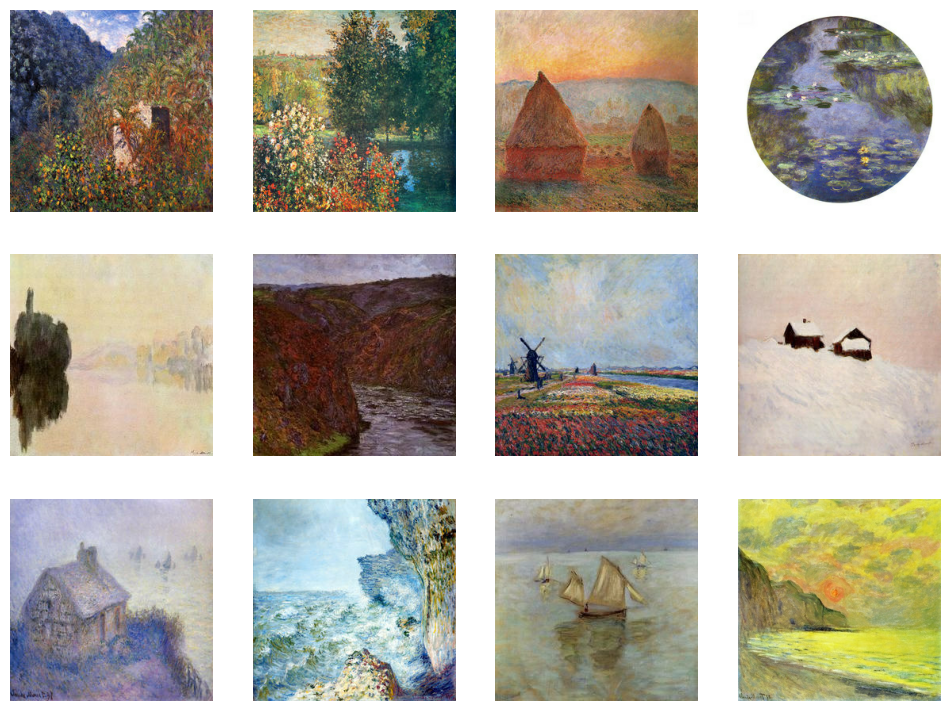

In [9]:
monet_batch = next(iter(monet_set))

def show_batch(img_batch):
   plt.figure(figsize=(12, 9))
   for n in range(12):
      ax = plt.subplot(3, 12//3, n+1)
      plt.imshow(img_batch[n]*0.5 + 0.5)
      plt.axis('off')

show_batch(monet_batch.numpy())

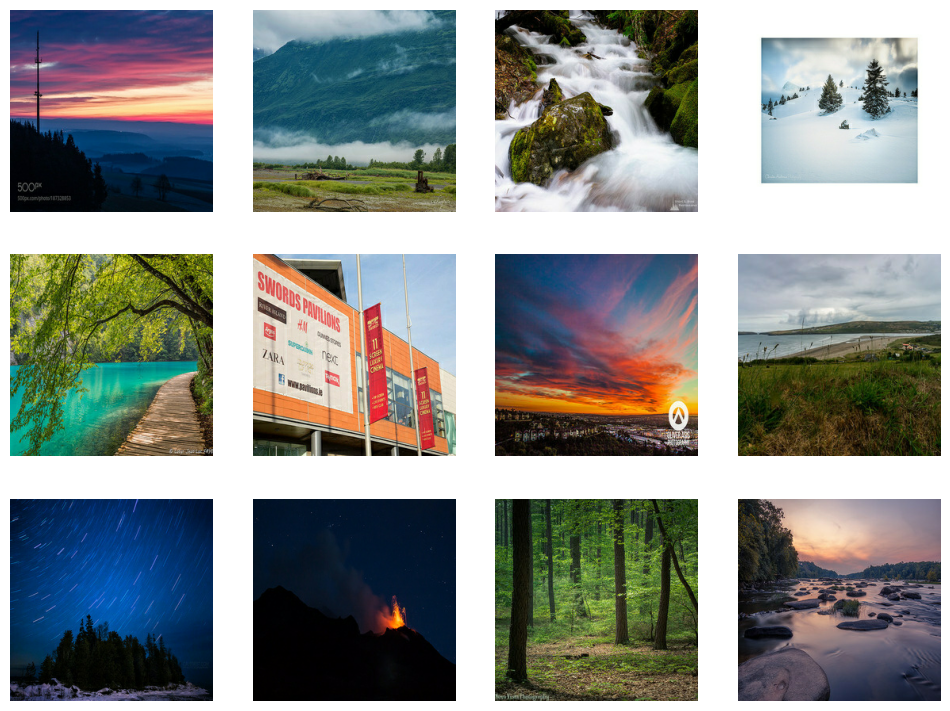

In [10]:
photo_batch = next(iter(photo_set))
show_batch(photo_batch.numpy())

## Building the models

#### For this project, I will implement a DCGAN, Deep Convolutional Generative Adversarial Network. I based most of this off of the Tensorflow tutorial from https://www.tensorflow.org/tutorials/generative/dcgan with modified image sizes and filters.

## First, the Generator

#### The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [29]:
noise_shape = 100

def generator_model():
   model = tf.keras.Sequential()
   model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_shape,)))
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   model.add(layers.Reshape((8, 8, 512)))
   assert model.output_shape == (None, 8, 8, 512)

   model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2,2), padding='same', use_bias=False))
   assert model.output_shape == (None, 16, 16, 256)
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
   assert model.output_shape == (None, 32, 32, 128)
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
   assert model.output_shape == (None, 64, 64, 64)
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
   assert model.output_shape == (None, 128, 128, 32)
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU())

   model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
   assert model.output_shape == (None, 256, 256, 3)

   return model

### Generating an image from the untrained Generator

/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


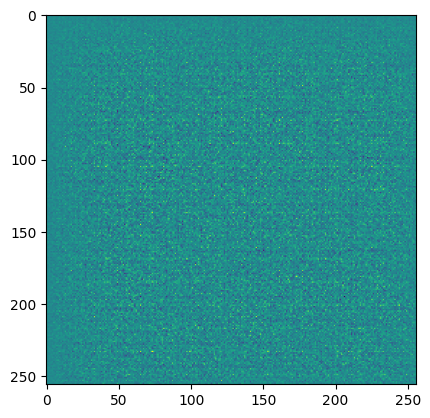

In [30]:
generator_1 = generator_model()

noise = tf.random.normal([1, noise_shape])
generated_image = generator_1(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

## Next, the Discriminator

#### The discriminator is a CNN-based image classifier that will classify the generated images as real or fake. The model will be trained to output positive values for real images and negative values for fake images.

In [31]:
def discriminator_model():
    # model = tf.keras.Sequential()
    # model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[256,256,3]))
    
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))
    
    # model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))
    
    # model.add(layers.Flatten())
    # model.add(layers.Dense(1))
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), strides=(2,2), padding='same', input_shape=[256,256,3]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

### Test out the untrained discriminator and our generated image from above.

In [32]:
discriminator_1 = discriminator_model()
decision = discriminator_1(generated_image)
print(decision)

/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.5000467]], shape=(1, 1), dtype=float32)


## Defining Loss Functions

In [61]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [62]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [63]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Defining Optimizers for Generator and Discriminator

In [64]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Creating Checkpoints

#### During one of the previous projects, I ran into problems during training with Tensorflow where my kernel would crash during the epochs. Creating checkpoints to save and restore models is a great idea if training is interupted again.

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_1,
                                 discriminator=discriminator_1)

In [38]:
EPOCHS = 200
samples_to_generate = 12

seed = tf.random.normal([samples_to_generate, noise_shape])

In [65]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, gen, disc):
    noise = tf.random.normal([BATCH_SIZE, noise_shape])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = gen(noise, training=True)

      real_output = disc(images, training=True)
      fake_output = disc(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

## Training Loop

In [66]:
def generate_images(model):
   noise = tf.random.normal([BATCH_SIZE, noise_shape])
   preds = model.predict(noise)
   return preds

def generate_and_plot_images(model, epoch):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  #predictions = model(test_input, training=False)
  image = generate_images(model)
  gen_img = 0.5 * image + 0.5

  fig = plt.figure(figsize=(12, 9))

  for i in range(12):
      plt.subplot(3, 4, i+1)
      plt.imshow(gen_img[i, :, :, :])
      plt.axis('off')

  plt.savefig('{}_image_at_epoch_{:04d}.png'.format(model, epoch))
  plt.show()

In [67]:
def train(dataset, epochs, gen, disc):
    generator = gen
    discriminator = disc
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch, generator, discriminator)

        if (epoch + 1) % 20 == 0:
            # checkpoint.save(file_prefix = checkpoint_prefix)
            display.clear_output(wait=True)
            print(f"Time for epoch {epoch+ 1} is : {time.time()-start}")
            generate_and_plot_images(generator, epoch)
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_plot_images(generator, epoch)
    

## Train the Model

#### Below is the final sample of images after 200 epochs of the first model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


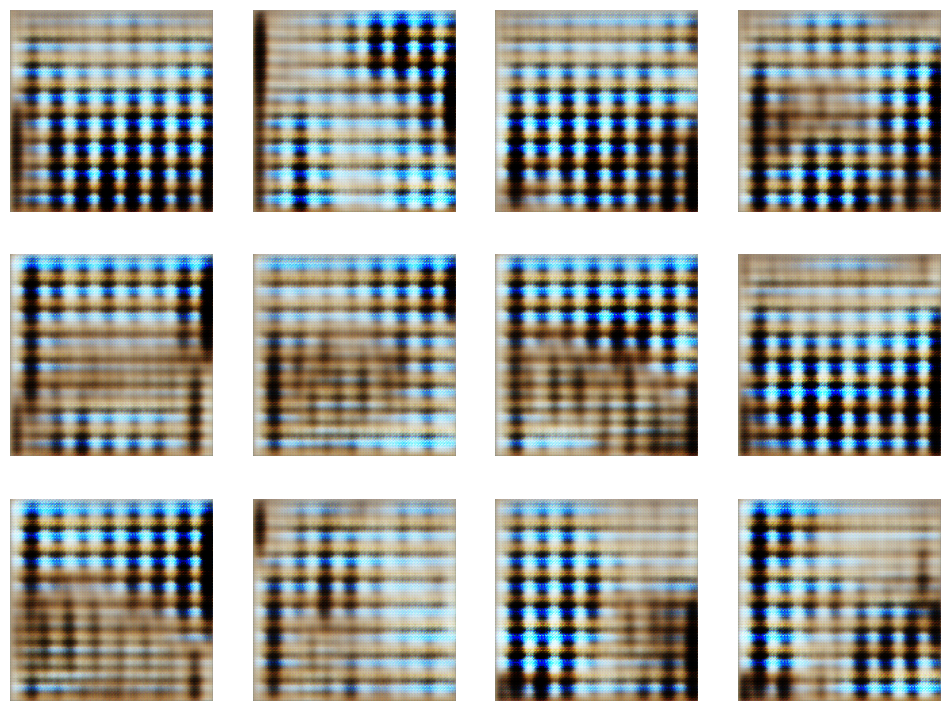

In [46]:
train(monet_set, EPOCHS, generator_1, discriminator_1)

## Modifying the Generator and Discriminator to retrain

#### Since the generated images above didn't really look like Monet paintings, I made changes for a second model to see if it does better. I added a couple layers in both the generator and discriminator. I changed the filter size from (5, 5) to (3, 3), added the alpha=0.2 to the Leaky ReLu activition which I saw in another tutorial. I also removed the use_bias=False argument in the Conv2D layers.

In [47]:
def generator_model_2():
   model = tf.keras.Sequential()
   model.add(layers.Dense(16*16*512, input_shape=(noise_shape,)))

   model.add(layers.Reshape((16, 16, 512)))
   assert model.output_shape == (None, 16, 16, 512)

   model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2,2), padding='same'))
   assert model.output_shape == (None, 32, 32, 256)
   model.add(layers.LeakyReLU(alpha=0.2))

   model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
   assert model.output_shape == (None, 64, 64, 128)
   model.add(layers.LeakyReLU(alpha=0.2))

   model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
   assert model.output_shape == (None, 128, 128, 64)
   model.add(layers.LeakyReLU(alpha=0.2))

   model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'))
   assert model.output_shape == (None, 256, 256, 32)
   model.add(layers.LeakyReLU(alpha=0.2))

   model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', activation='tanh'))

   return model

/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


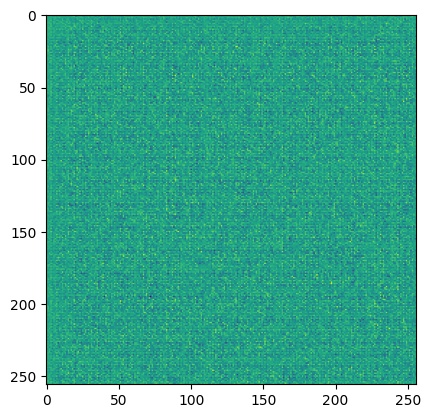

In [68]:
generator_2 = generator_model_2()

noise = tf.random.normal([1, noise_shape])
generated_image = generator_2(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [51]:
def discriminator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), strides=(2,2), padding='same', input_shape=[256,256,3]))
    
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (3,3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [69]:
discriminator_2 = discriminator_model_2()
decision = discriminator_2(generated_image)
print(decision)

/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.50002176]], shape=(1, 1), dtype=float32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


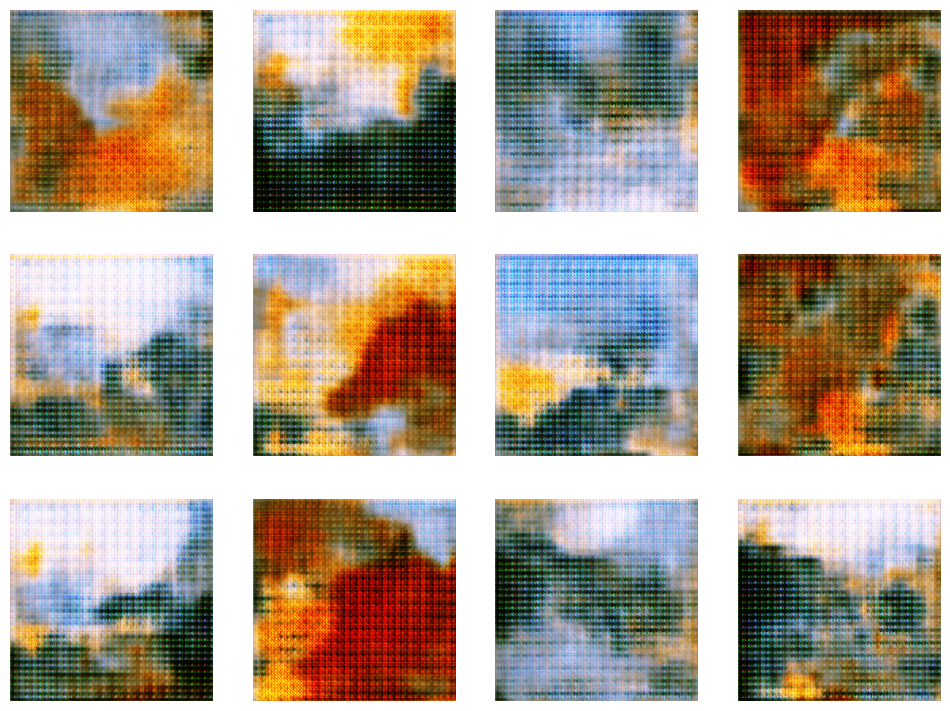

In [70]:
train(monet_set, EPOCHS, generator_2, discriminator_2)

## Observations after the first 200 epochs

#### These outputs from the second model look much better than the first model. The images are starting to resemble some Monet paintings so I decided to run the training again for another 200 epochs on the same model to see how that went.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


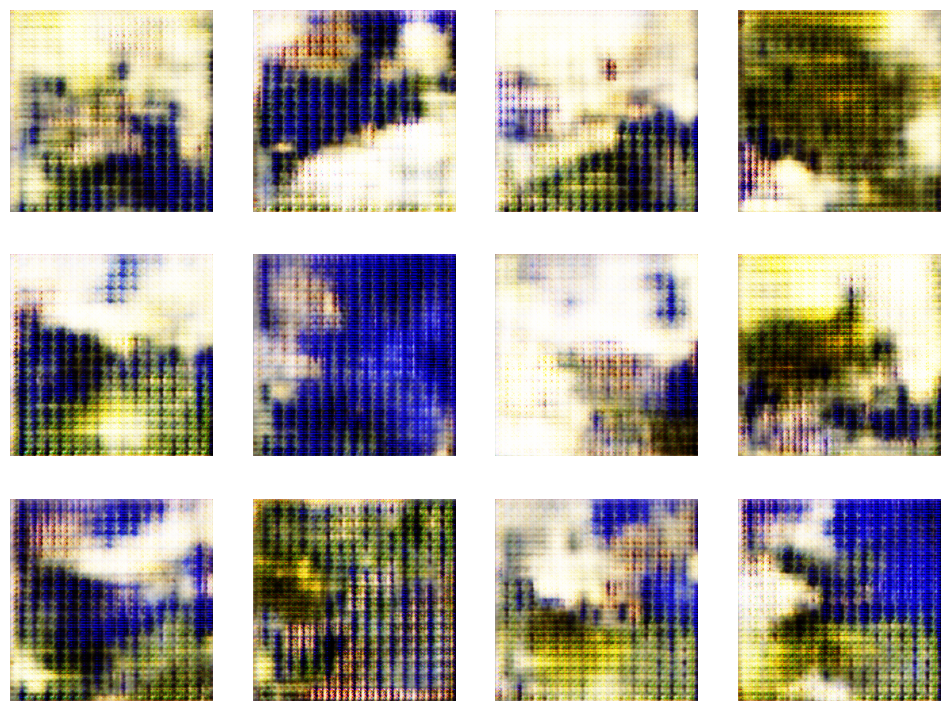

In [71]:
train(monet_set, EPOCHS, generator_2, discriminator_2)

#### After another 200 epochs, the images actually don't look as good as the ones before. I thought the model would improve with more time but it looks like some more tweaks would need to be done form more improvement.

## Findings and Conclusion

#### For this project, I decided to go with a DCGAN, but doing some other research and seeing what others did for the competition, a CycleGAN seems to produce better results. For applying a Monet type filter to photos, the CycleGan seems better, but the DCGAN did pretty well at learning what the Monet paintings look like and generating images that resemble it. With more time, modifications would be made for the generator and discriminator and ran for more epochs to produce better results. I think for my first time working with GANs, the results are pretty good andf I enjoyed learning and working on this project.

## Creating Submission ZIP file

In [72]:
print(os.getcwd())

/Users/johnkaiser/Documents/MSDS/Spring 2024/5511 Deep Learning


In [73]:
!mkdir ./images

In [74]:
from PIL import Image

In [75]:
start = time.time()
for i in range(7000):
   noise = tf.random.normal([BATCH_SIZE, noise_shape])
   img = generator_2.predict(noise)
   img = 0.5 * img + 0.5
   img = (img * 255).astype('uint8')
   img = Image.fromarray(img[0, :, :, :])
   img.save("./images/" + str(i) + ".jpg")
print('Total running time is {} sec'.format(time.time()-start))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


/Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━